# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.039313,False,-0.682894
1,1.426841,True,7.943303
2,-0.862162,False,0.078554
3,-0.781227,False,-2.761173
4,-0.852151,False,-2.593763
...,...,...,...
995,0.216387,False,0.386972
996,0.825846,True,5.992411
997,-0.606425,True,3.575475
998,1.893887,True,9.933711


<AxesSubplot:xlabel='v0'>

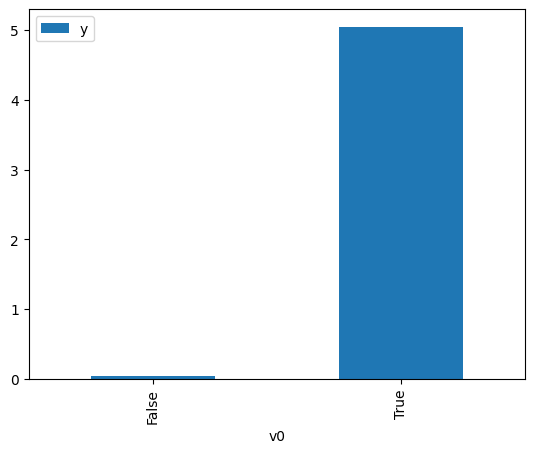

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

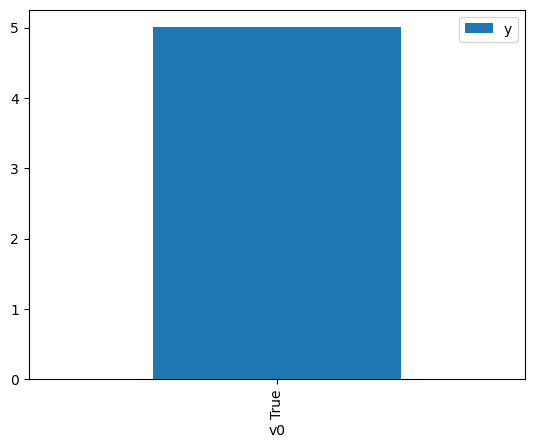

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.026591,False,-2.382183,0.862837,1.158967
1,-1.014832,False,0.358930,0.860156,1.162580
2,0.213210,False,0.379669,0.370406,2.699742
3,0.059384,False,0.566977,0.441154,2.266783
4,1.645097,False,4.496857,0.036716,27.235991
...,...,...,...,...,...
995,1.645097,False,4.496857,0.036716,27.235991
996,-0.140891,False,0.031862,0.536507,1.863907
997,1.645097,False,4.496857,0.036716,27.235991
998,-0.060268,False,-0.275071,0.498050,2.007829


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.343836,True,5.692478,0.685708,1.458346
1,-1.665111,True,1.406348,0.044813,22.315070
2,1.097323,True,7.469410,0.902050,1.108586
3,0.549254,True,6.490849,0.763639,1.309520
4,-0.254728,True,3.232032,0.410026,2.438870
...,...,...,...,...,...
995,1.077131,True,6.155994,0.898587,1.112858
996,-0.405513,True,3.245364,0.342530,2.919455
997,-0.117826,True,4.070460,0.474470,2.107614
998,-0.442822,True,3.074279,0.326656,3.061322


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.066e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        18:13:50   Log-Likelihood:                         -1437.8
No. Observations:                1000   AIC:                                      2880.
Df Residuals:                     998   BIC:                                      2889.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7551      0.038     46.765      0.000       1.681       1.829
x2             4.9372      0.049    100.631      0.000       4.841       5.034
==============================================================================
Omnibus:                        2.252   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                2.332
Skew:                          -0.009   Prob(JB):                        0.312
Kurtosis:                       3.236   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""